In [8]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.corpus.reader.util import tempfile
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim import downloader as api
from tensorflow.keras.layers import InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras_tuner import RandomSearch

## First Tuning

In [ ]:
# load Word2Vec embeddings
word2vec_model = api.load("word2vec-google-news-300")

In [ ]:
# get NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the full dataset
df = pd.read_csv('/Users/arthur/My Drive/Education/Master/Copenhagen Business School/2. Semester/Natural Language Processing and Text Analytics/Assignments/Final Assignment/news.csv')
# function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

# apply function
df['news'] = df['news'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# sample 10,000 rows
df_short = df.sample(n=10000, random_state=42)

# tokenize as before
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_short['news'])
sequences = tokenizer.texts_to_sequences(df_short['news'])

# padding again, but this time to 200
max_sequence_length = 200
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# encoding as before
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_short['category'])
labels = to_categorical(labels)  # Convert labels to categorical

# train test split as before
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


# creating embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.key_to_index:
        embedding_matrix[i] = word2vec_model[word]

# search for units, dropout and learning rate
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units_1', [32, 64, 128]), return_sequences=True)))
    model.add(Dropout(hp.Choice('dropout_rate_1', [0.0, 0.3, 0.5])))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units_2', [32, 64, 128]))))
    model.add(Dropout(hp.Choice('dropout_rate_2', [0.0, 0.3, 0.5])))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # Choose the learning rate
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

# temp directory to save results temporarily
temp_dir = tempfile.mkdtemp()

# create tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory=temp_dir,
    project_name='news_category_tuning'
)

# start hyperparameter search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

# get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')},
the optimal number of units in the second LSTM layer is {best_hps.get('lstm_units_2')},
the optimal dropout rate for the first LSTM layer is {best_hps.get('dropout_rate_1')},
and the optimal dropout rate for the second LSTM layer is {best_hps.get('dropout_rate_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 06m 50s]
val_accuracy: 0.7264999747276306

Best val_accuracy So Far: 0.7444999814033508
Total elapsed time: 06h 32m 25s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 32,
the optimal number of units in the second LSTM layer is 64,
the optimal dropout rate for the first LSTM layer is 0.0,
and the optimal dropout rate for the second LSTM layer is 0.5.
The optimal learning rate is 0.01.



### Alternative tuner to test different configuration (similar setup)

In [ ]:
# sample
df_short = df.sample(n=10000, random_state=42)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_short['news'])
sequences = tokenizer.texts_to_sequences(df_short['news'])

max_sequence_length = 200
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_short['category'])
labels = to_categorical(labels)  # Convert labels to categorical

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


# embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.key_to_index:
        embedding_matrix[i] = word2vec_model[word]

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units_1', [32, 64, 128]), return_sequences=True)))
    model.add(Dropout(hp.Choice('dropout_rate_1', [0.0, 0.3, 0.5])))
    model.add(Bidirectional(LSTM(hp.Choice('lstm_units_2', [32, 64, 128]))))
    model.add(Dropout(hp.Choice('dropout_rate_2', [0.0, 0.3, 0.5])))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # including learning rate
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])

    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

temp_dir = tempfile.mkdtemp()

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory=temp_dir,
    project_name='news_category_tuning'
)

#  start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# printing the optimal hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')},
the optimal number of units in the second LSTM layer is {best_hps.get('lstm_units_2')},
the optimal dropout rate for the first LSTM layer is {best_hps.get('dropout_rate_1')},
and the optimal dropout rate for the second LSTM layer is {best_hps.get('dropout_rate_2')}.
""")

Trial 10 Complete [00h 05m 21s]
val_accuracy: 0.7164999842643738

Best val_accuracy So Far: 0.7409999966621399
Total elapsed time: 02h 19m 42s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 128,
the optimal number of units in the second LSTM layer is 64,
the optimal dropout rate for the first LSTM layer is 0.5,
and the optimal dropout rate for the second LSTM layer is 0.0.



## Final Tuner

In [ ]:
# load dataset and sample 20,000 rows this time for the final tuner
df = pd.read_csv('/Users/arthur/My Drive/Education/Master/Copenhagen Business School/2. Semester/Natural Language Processing and Text Analytics/Assignments/Final Assignment/news.csv')
df = df.sample(20000, random_state=42)

# load Word2Vec model
w2v_model = api.load("word2vec-google-news-300")

# load spacy model
nlp = spacy.load('en_core_web_sm')

# function to tokenize, lowercase, remove stopwords and punctuation
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    return tokens

# apply preprocessing function to news text
df['tokens'] = df['news'].apply(preprocess_text)

# generate sequences with word2vec
def generate_sequences(tokens, w2v_model, oov_token='UNK'):
    sequence = []
    for word in tokens:
        if word in w2v_model.key_to_index:
            sequence.append(w2v_model[word])
        else:
            sequence.append(np.zeros(w2v_model.vector_size))
    return sequence

# apply the embedding function to the tokens column
df['sequences'] = df['tokens'].apply(lambda x: generate_sequences(x, word2vec_model))

# determine the maximum sequence length
max_sequence_length = max(df['sequences'].apply(len))

# pad the sequences to the maximum length
X = pad_sequences(df['sequences'].to_list(), maxlen=max_sequence_length, padding='post', dtype='float32')

# label encodinng for categories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

# train test split for model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# searching for different number of Bidirectionl-LSTM layers and Dense layers
# For each searching for optimal units and dropout, as well as the learning rate
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())
    
    # Adding BiLSTM layer
    for i in range(hp.Int('num_bilstm_layers', 1, 3)):
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'bilstm_{i}_units', min_value=32, max_value=256, step=32),
            return_sequences=True if i < hp.Int('num_bilstm_layers', 1, 3) - 1 else False
        )))
        model.add(Dropout(hp.Float('bilstm_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Adding Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', min_value=64, max_value=256, step=64)
        ))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='/Users/arthur/Downloads/tuning2',
    project_name='final_test_bilstm2'
)

# early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)

# start the tuner
tuner.search(
    X_train, y_train, epochs=15, validation_split=0.2, callbacks=[early_stopping]
)

# get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# print scores
loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Trial 30 Complete [00h 43m 31s]
val_accuracy: 0.7087500095367432

Best val_accuracy So Far: 0.7712500095367432
Total elapsed time: 15h 50m 09s
Best Hyperparameters:
{'num_bilstm_layers': 2, 'bilstm_0_units': 256, 'bilstm_dropout': 0.5, 'num_dense_layers': 2, 'dense_0_units': 192, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.001, 'dense_1_units': 192, 'dense_2_units': 64, 'bilstm_1_units': 64, 'bilstm_2_units': 224}


/Users/arthur/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 119, 300)       │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 119, 512)       │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 119, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         2,123 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501,307 (5.73 MB)

 Trainable params: 1,500,707 (5.72 MB)

 Non-trainable params: 600 (2.34 KB)

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.7567 - loss: 0.8631
Test Accuracy: 0.7515000104904175


## Final Model

In [2]:
# Load your dataset
full_df = pd.read_csv('/Users/arthur/My Drive/Education/Master/Copenhagen Business School/2. Semester/Natural Language Processing and Text Analytics/Assignments/Final Assignment/news.csv')

# Load pre-trained Word2Vec model using gensim downloader
w2v_model = api.load("word2vec-google-news-300")

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Tokenize the text, remove stop words, remove punctuation, and convert to lowercase
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    return tokens

# Apply preprocessing to the 'news' column
full_df['tokens'] = full_df['news'].apply(preprocess_text)

In [4]:
def generate_sequences(tokens, w2v_model, oov_token='UNK'):
    sequence = []
    for word in tokens:
        if word in w2v_model.key_to_index:
            sequence.append(w2v_model[word])
        else:
            # If word is OOV, use a vector of zeros
            sequence.append(np.zeros(w2v_model.vector_size))
    return sequence

# Apply the embedding function to the tokens column
full_df['sequences'] = full_df['tokens'].apply(lambda x: generate_sequences(x, w2v_model))

In [5]:
# Determine the maximum sequence length
max_sequence_length = max(full_df['sequences'].apply(len))

# Pad sequences to the same length
X = pad_sequences(full_df['sequences'].to_list(), maxlen=max_sequence_length, padding='post', dtype='float32')

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(full_df['category'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def build_final_model(hp):
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))  # Updated line
    model.add(BatchNormalization())
    
    # Adding BiLSTM layer
    for i in range(hp.get('num_bilstm_layers')):
        model.add(Bidirectional(LSTM(
            units=hp.get(f'bilstm_{i}_units'),
            return_sequences=True if i < hp.get('num_bilstm_layers') - 1 else False
        )))
        model.add(Dropout(hp.get('bilstm_dropout')))
    
    # Adding Dense layers
    for i in range(hp.get('num_dense_layers')):
        model.add(Dense(
            units=hp.get(f'dense_{i}_units')
        ))
        model.add(Dropout(hp.get('dense_dropout')))

    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.get('learning_rate')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Get the best hyperparameters
best_hyperparameters = {'num_bilstm_layers': 2, 
                        'bilstm_0_units': 256, 
                        'bilstm_dropout': 0.5, 
                        'num_dense_layers': 2, 
                        'dense_0_units': 192, 
                        'dense_dropout': 0.3, 
                        'learning_rate': 0.001, 
                        'dense_1_units': 192, 
                        'dense_2_units': 64, 
                        'bilstm_1_units': 64, 
                        'bilstm_2_units': 224
                        }


Epoch 1/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1373s 479ms/step - accuracy: 0.6801 - loss: 1.0351 - val_accuracy: 0.7943 - val_loss: 0.6634
Epoch 2/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1275s 445ms/step - accuracy: 0.7948 - loss: 0.6965 - val_accuracy: 0.8019 - val_loss: 0.6480
Epoch 3/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1286s 449ms/step - accuracy: 0.8191 - loss: 0.6148 - val_accuracy: 0.8043 - val_loss: 0.6597
Epoch 4/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1259s 440ms/step - accuracy: 0.8358 - loss: 0.5507 - val_accuracy: 0.8052 - val_loss: 0.6632
Epoch 5/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1256s 439ms/step - accuracy: 0.8523 - loss: 0.5075 - val_accuracy: 0.8084 - val_loss: 0.6971
Epoch 6/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1310s 457ms/step - accuracy: 0.8652 - loss: 0.4646 - val_accuracy: 0.8009 - val_loss: 0.7511
Epoch 7/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1280s 447ms/step - accuracy: 0.8758 - loss: 0.4251 - val_accuracy: 0.8029 - val_loss: 0.7715
Epoch 8/15
2864/2864 ━━━━━━━━━━━━━━━━━━━━ 1357s 474ms/s

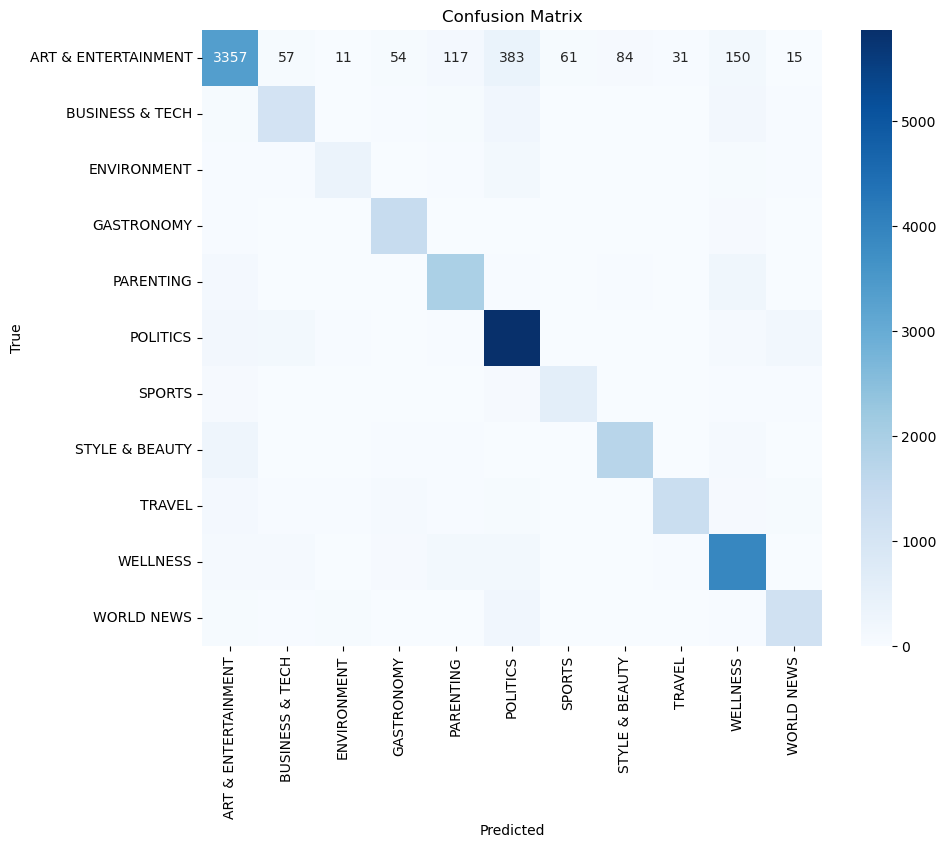

In [9]:
# Train the final model on the full training dataset
final_model = build_final_model(best_hyperparameters)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)

history = final_model.fit(
    X_train, y_train, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Predict the test set
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the final model
final_model.save('/Users/arthur/Downloads/tuning2/final_model.h5')

# Save the label encoder
with open('/Users/arthur/Downloads/tuning2/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Document the best hyperparameters
with open('/Users/arthur/Downloads/tuning2/best_hyperparameters.txt', 'w') as file:
    file.write(str(best_hyperparameters.values))

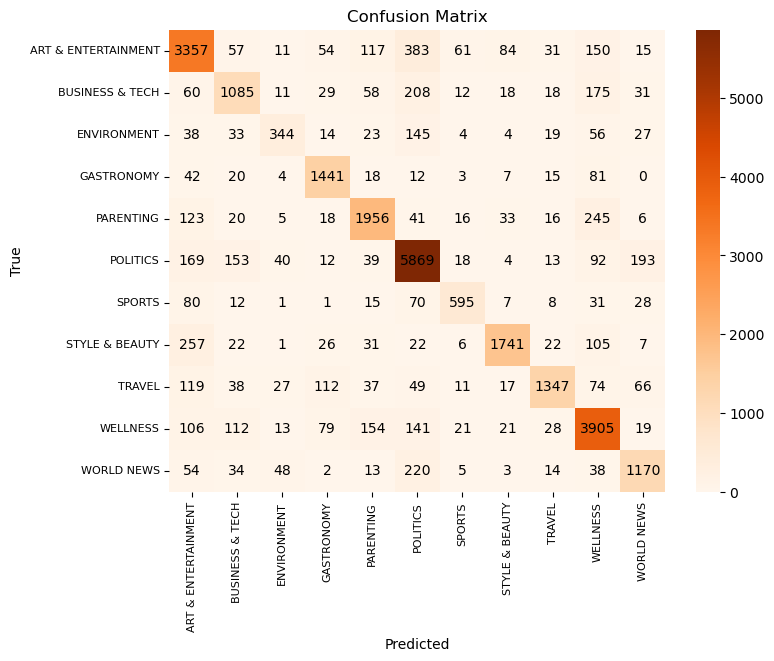

In [54]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=True)

# Annotate each cell with the corresponding value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black')
        
# Tilt the x-axis labels and align them so the end of the word starts at the tick
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

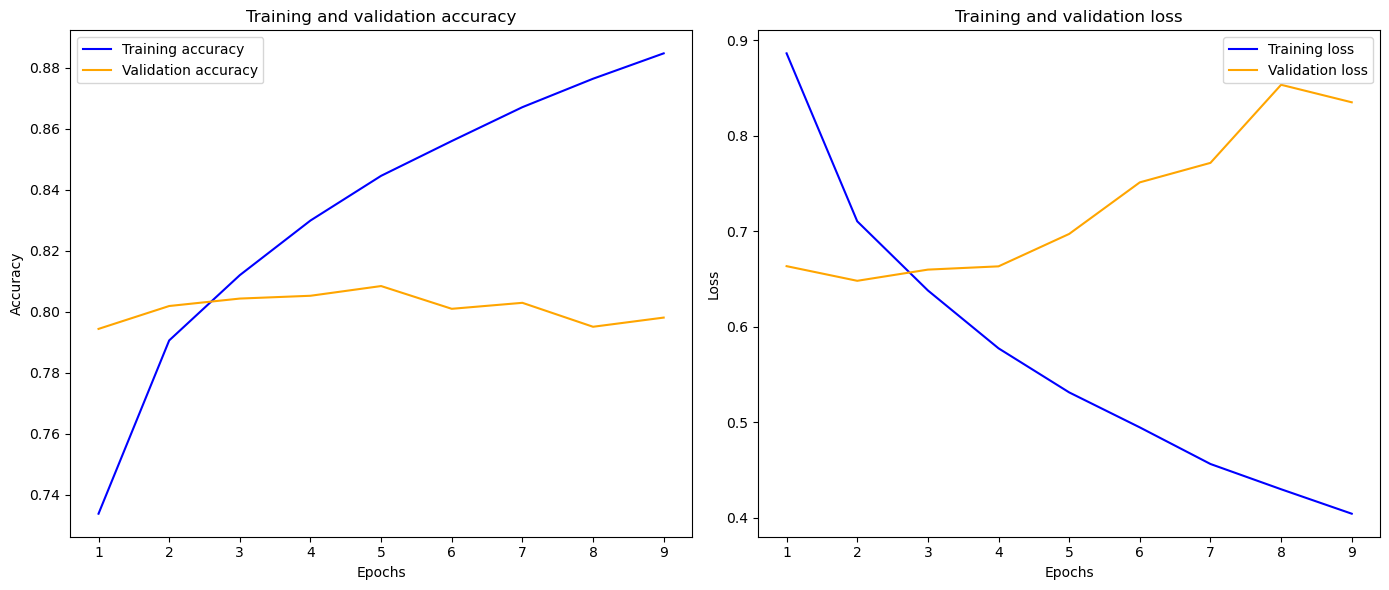

In [57]:
# Accuracy and loss plots:

history_dict = history.history
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

# Determining the number of epochs based on the length of the accuracy list:
epochs = range(1, len(accuracy) + 1)

# Plotting the training and validation accuracy:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b-", label="Training accuracy")
plt.plot(epochs, val_accuracy, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the training and validation loss:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Adjusting layout:
plt.tight_layout()

# Saving plots as a PNG file:
plt.savefig("/Users/arthur/Downloads/tuning2/training_validation_plot_final_2.png")

# Displaying the plots:
plt.show()

In [59]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 126, 300)       │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 126, 512)       │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 126, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         2,123 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,502,723 (17.18 MB)

 Trainable params: 1,500,707 (5.72 MB)

 Non-trainable params: 600 (2.34 KB)

 Optimizer params: 3,001,416 (11.45 MB)